# Introduction

### Background:
 Diaporthe citri, the causal agent of citrus melanose, is a hemi-biotrophic fungus that infects citrus and related genera. It produces raised, reddish-brown lesions on leaves, twigs, and fruit, which may coalesce under humid conditions to form large, cracked patches known as “mudcake” (Figure 1). This disease reduces citrus yield by causing premature fruit and leaf drop and diminishes the marketability of fresh fruit. While pruning dead wood—where the fungus reproduces—can limit spread, this method is labor-intensive. As a result, chemical controls like copper- and strobilurin-based fungicides are widely used, though they pose environmental and phytotoxic risks. Given the absence of resistant cultivars and increasing concerns over chemical inputs, alternative solutions such as biological control are gaining interest.

![Petri Dish Prediction](petri.png)

 Biological control employs naturally occurring microbes to suppress plant pathogens through mechanisms such as antibiosis, competition, parasitism, and induced systemic resistance. Prior research highlights the potential of bacterial and fungal antagonists as sustainable tools in disease management.

# Materials and Methods for Data Acquisition

### Antagonism Assay and Image Acquisition:
To identify native bacterial isolates with antagonistic activity against D. citri, we screened 77 isolates collected from citrus tissue using in vitro dual-culture assays. After incubation, petri dishes were photographed inside a custom-built photobox (Smith & Schuster, 2021), which ensured high-resolution, standardized images by controlling lighting, minimizing reflections, and maintaining consistent camera placement.

### Manual Image Analysis:
All 274 images, including experimental assays and controls, were analyzed using Fiji (version 2.13.1) (Schindelin et al., 2012). Fungal colonies were manually outlined using the paintbrush tool (magenta, 20-pixel width), and a macro script was run in batch mode to calculate colony area. The script calibrated scale using a reference ruler image, thresholded the outlines, generated a binary mask, and computed area measurements (Figure 2). While this method is highly accurate, it is time-intensive—averaging 48 seconds per image, the analysis of the full dataset required nearly 3 hours and 40 minutes.

![Manual Workflow](manual_workflow.png)

This led us to a central question: 

### Can we develop a machine learning algorithm to replace manual outlining and automate fungal area quantification—saving time while maintaining accuracy?

Below we aim to answer that question.

## Import packages and set packages

In [27]:
import segmentation_models_pytorch as smp
import torch.nn as nn
import torch.optim as optim
import torch
from torchinfo import summary
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import torchvision.transforms as T
import os
from PIL import Image
import numpy as np

In [28]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'


In [29]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Set up Unet model

In [30]:
model = smp.Unet('resnet34', classes=3, activation='softmax').to(device)

In [31]:
summary(model)

Layer (type:depth-idx)                        Param #
Unet                                          --
├─ResNetEncoder: 1-1                          --
│    └─Conv2d: 2-1                            9,408
│    └─BatchNorm2d: 2-2                       128
│    └─ReLU: 2-3                              --
│    └─MaxPool2d: 2-4                         --
│    └─Sequential: 2-5                        --
│    │    └─BasicBlock: 3-1                   73,984
│    │    └─BasicBlock: 3-2                   73,984
│    │    └─BasicBlock: 3-3                   73,984
│    └─Sequential: 2-6                        --
│    │    └─BasicBlock: 3-4                   230,144
│    │    └─BasicBlock: 3-5                   295,424
│    │    └─BasicBlock: 3-6                   295,424
│    │    └─BasicBlock: 3-7                   295,424
│    └─Sequential: 2-7                        --
│    │    └─BasicBlock: 3-8                   919,040
│    │    └─BasicBlock: 3-9                   1,180,672
│    │    └─Basi

### Model Preparation and Dataset Pipeline Overview

This section sets up the U-Net model and prepares the custom dataset for semantic segmentation of Petri dish images.

####  Model Configuration
- The U-Net model is instantiated with a ResNet34 encoder and softmax activation to produce a 3-class output: background, dish, and pathogen.
- The encoder (backbone) is frozen using `param.requires_grad = False`, meaning only the decoder and segmentation head will be trained. This reduces training time and leverages pretrained features.
- The optimizer is configured to only update the decoder and segmentation head parameters using Adam with a learning rate of 1e-4.
- CrossEntropyLoss is used as the loss function, appropriate for multi-class classification tasks.


In [32]:
for param in model.encoder.parameters():
    param.requires_grad = False

In [33]:
loss_fn = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam([
    {'params': model.decoder.parameters()},
    {'params': model.segmentation_head.parameters()}
], lr=1e-4)

###  Dataset Directories
- `image_dir` and `mask_dir` point to local folders that contain the input images and their corresponding segmentation masks, respectively.

#### Custom Dataset Class (`SegmentationDataset`)
- This subclass of `torch.utils.data.Dataset` loads only valid `.png` mask files that have a corresponding `.jpg` image.
- In `__getitem__`, both the input image and mask are opened, transformed (e.g., normalized or tensor-converted), and returned as a pair for model training.

In [34]:
mask_dir = os.path.join(os.getcwd(),"labels/final_labels")
image_dir= os.path.join(os.getcwd(),"images_224_rename")

In [35]:
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir,
                 transform=None, mask_transform=None):

        self.image_dir      = image_dir
        self.mask_dir       = mask_dir
        self.transform      = transform
        self.mask_transform = mask_transform

        # *** keep only mask files that really exist and match a .jpg ***
        self.image_filenames = sorted([
            f for f in os.listdir(mask_dir)
            if f.endswith(".png")                                  # only masks
            and os.path.isfile(os.path.join(mask_dir, f))          # skip dirs
            and os.path.isfile(os.path.join(image_dir,
                                            f.replace(".png", ".jpg")))  # paired img
        ])

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        mask_name  = self.image_filenames[idx]            # e.g. 001.png
        img_name   = mask_name.replace(".png", ".jpg")     # e.g. 001.jpg

        img_path   = os.path.join(self.image_dir, img_name)
        mask_path  = os.path.join(self.mask_dir,  mask_name)

        image = Image.open(img_path).convert("RGB")
        mask  = Image.open(mask_path).convert("L")         # 1‑channel

        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask




####  Transforms
- Images are normalized to match ImageNet statistics using `ToTensor()` and `Normalize(...)`.
- Masks are converted to long integer tensors using `PILToTensor()` and reshaped appropriately.

####  DataLoader
- A `DataLoader` is created with a batch size of 10 and shuffling enabled to feed batches of image-mask pairs to the model during training.

This setup ensures that the U-Net is efficiently trained on well-matched image/mask pairs, and it standardizes the preprocessing pipeline to align with expected input formats.


In [36]:
image_transform = T.Compose([
    T.ToTensor(),  # [0,1] 
    T.Normalize(mean=[0.485, 0.456, 0.406],  
                std=[0.229, 0.224, 0.225])
])

In [37]:
# turn mask to tensor
mask_transform = T.Compose([
    T.PILToTensor(),
    T.Lambda(lambda x: x.squeeze().long())
])


In [38]:
# build Dataset
dataset = SegmentationDataset(
    image_dir=image_dir,
    mask_dir=mask_dir,
    transform=image_transform,
    mask_transform = mask_transform
)

In [39]:
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)

### Training and Evaluation Pipeline for U-Net

This section implements the model training loop, validation phase, and a utility function to save predictions for individual samples.

In [40]:
for imgs, masks in dataloader:
    print(imgs.shape, masks.shape)

torch.Size([10, 3, 224, 224]) torch.Size([10, 224, 224])
torch.Size([10, 3, 224, 224]) torch.Size([10, 224, 224])
torch.Size([10, 3, 224, 224]) torch.Size([10, 224, 224])
torch.Size([10, 3, 224, 224]) torch.Size([10, 224, 224])
torch.Size([10, 3, 224, 224]) torch.Size([10, 224, 224])


### Pixel_accuracy 

Calculates per-pixel accuracy by comparing predicted class IDs to ground truth mask labels. It assumes both are shaped [B, H, W]. Useful for tracking segmentation performance during evaluation.

In [41]:
def pixel_accuracy(preds, masks):
    """
    preds: prediction, shape = (B, H, W)
    masks: ground truth mask，shape = (B, H, W)
    """
    correct = (preds == masks).float()
    acc = correct.sum() / correct.numel()
    return acc

### Model Training Loop and evaluation

- Sets the model to training mode using model.train().
- Iterates over batches of images/masks from the DataLoader.
- Moves data to the GPU, computes predictions, evaluates loss (CrossEntropyLoss), and updates the model using backpropagation.
- Tracks cumulative loss per epoch.

Evaluation:
- Switches the model to inference mode (disables dropout, batchnorm updates).
- Evaluates the model without computing gradients for faster performance.
- For each batch:
    - Predicts segmentation maps.
    - Computes loss and pixel-wise accuracy.
Outputs averaged loss and accuracy per epoch.

In [ ]:
model.train()
for epoch in range(20):
    model.train()
    total_loss = 0
    for imgs, masks in dataloader:
        imgs = imgs.to(device)
        masks = masks.long().squeeze(1).to(device)  

        outputs = model(imgs)
        loss = loss_fn(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    model.eval()
    with torch.inference_mode():
        val_loss = 0
        val_acc = 0
        val_batches = 0
    
        for imgs, masks in dataloader:
            imgs = imgs.to(device)
            masks = masks.long().squeeze(1).to(device)
            
            outputs = model(imgs)
            preds = torch.argmax(outputs, dim=1)
            loss = loss_fn(outputs, masks)
            acc = pixel_accuracy(preds, masks)
    
            val_loss += loss.item()
            val_acc += acc.item()
            val_batches += 1
    
        avg_loss = val_loss / val_batches
        avg_acc = val_acc / val_batches
        print(f"Epoch [{epoch+1}], Accuracy: {avg_acc:.4f}, Loss: {avg_loss:.4f}")

Epoch [1], Accuracy: 0.9776, Loss: 0.7005
Epoch [2], Accuracy: 0.9781, Loss: 0.6914
Epoch [3], Accuracy: 0.9789, Loss: 0.6830
Epoch [4], Accuracy: 0.9823, Loss: 0.6735
Epoch [5], Accuracy: 0.9839, Loss: 0.6654
Epoch [6], Accuracy: 0.9854, Loss: 0.6580
Epoch [7], Accuracy: 0.9867, Loss: 0.6518
Epoch [8], Accuracy: 0.9870, Loss: 0.6466
Epoch [9], Accuracy: 0.9881, Loss: 0.6415
Epoch [10], Accuracy: 0.9872, Loss: 0.6379
Epoch [11], Accuracy: 0.9896, Loss: 0.6330
Epoch [12], Accuracy: 0.9913, Loss: 0.6289
Epoch [13], Accuracy: 0.9916, Loss: 0.6258
Epoch [14], Accuracy: 0.9914, Loss: 0.6228
Epoch [15], Accuracy: 0.9928, Loss: 0.6198
Epoch [16], Accuracy: 0.9929, Loss: 0.6171
Epoch [17], Accuracy: 0.9920, Loss: 0.6148
Epoch [18], Accuracy: 0.9921, Loss: 0.6126
Epoch [19], Accuracy: 0.9935, Loss: 0.6102
Epoch [20], Accuracy: 0.9937, Loss: 0.6082


In [45]:
from torchvision.utils import save_image

In [46]:
def save_file(idx):
    model.eval()
    save_dir = os.path.join(os.getcwd(),"labels/prediction")
    os.makedirs(save_dir, exist_ok=True)
    

    idx = idx 
    image, mask = dataset[idx]
    filename = dataset.image_filenames[idx]
    
    image_tensor = image.unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(image_tensor)
        pred = torch.argmax(output, dim=1) 

    pred_np = pred.squeeze().cpu().numpy().astype(np.uint8)
    pred_img = Image.fromarray(pred_np, mode='L')  
    
    # save path
    save_path = os.path.join(save_dir, filename)
    pred_img.save(save_path)


In [47]:
# save_file(0)

###  Visualization Utility – Compare Ground Truth vs Prediction

This section defines two utility functions to visualize and compare the model's predicted segmentation with the ground truth.



####  `visualize_simple(image, pred_mask, true_mask, class_colors)`

Displays three side-by-side panels using Matplotlib:
1. The original image.
2. The ground truth segmentation mask.
3. The predicted segmentation mask.

**Arguments:**
- `image` (`Tensor`): The input image tensor in shape `(C, H, W)`.
- `pred_mask` (`Tensor`): The predicted mask, typically shape `(H, W)`.
- `true_mask` (`Tensor`): The ground truth segmentation mask.
- `class_colors` (`dict`): A mapping of class indices to RGB color tuples.

The masks are first converted to NumPy arrays and then colorized using `mask_to_color()` before plotting.



####  `mask_to_color(mask, class_colors)`

Converts a 2D mask of class indices into a 3-channel RGB image using a provided color map.

**Arguments:**
- `mask` (`ndarray`): The segmentation mask with shape `(H, W)` containing class indices.
- `class_colors` (`dict`): A dictionary mapping class labels to RGB tuples.

**Returns:**
- A 3-channel color image (`H, W, 3`) where each class is visualized using the assigned color.

This is especially useful for qualitative comparison of predicted vs true segmentations.


In [48]:
import matplotlib.pyplot as plt
from torchvision.transforms import functional as TF

def visualize_simple(image, pred_mask, true_mask, class_colors):
    """
    Visualize the original image, prediction, and ground truth using Matplotlib

    Args:
        image (Tensor): Original image (C, H, W)
        pred_mask (Tensor): Prediction mask (H, W)
        true_mask (Tensor): Ground truth mask (H, W)
        class_colors (dict): RGB colors for each class
    """
    # Convert to numpy arrays
    image_np = TF.to_pil_image(image.cpu()).convert("RGB")
    pred_np = pred_mask.squeeze().cpu().numpy()
    true_np = true_mask.squeeze().cpu().numpy()

    # Map to color images
    pred_colored = mask_to_color(pred_np, class_colors)
    true_colored = mask_to_color(true_np, class_colors)

    # Plotting
    plt.figure(figsize=(12, 8))

    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(image_np)
    plt.title("Original Image")
    plt.axis("off")

    # Ground Truth
    plt.subplot(1, 3, 2)
    plt.imshow(true_colored)
    plt.title("Ground Truth")
    plt.axis("off")

    # Prediction
    plt.subplot(1, 3, 3)
    plt.imshow(pred_colored)
    plt.title("Prediction")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

def mask_to_color(mask, class_colors):
    """
    Convert a mask (H, W) to a color image using the provided class_colors

    Args:
        mask (ndarray): Mask (H, W)
        class_colors (dict): RGB colors for each class
    """
    color_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    for class_idx, color in class_colors.items():
        color_mask[mask == class_idx] = color
    return color_mask

In [49]:
def showCompare(index):
    image, label = dataset[index]
    image = image.to(device).unsqueeze(0)
    
    # predict
    model.eval()
    with torch.no_grad():
        output = model(image)
        pred = torch.argmax(output, dim=1)
    
    # define class color
    class_colors = {
        0: (0, 0, 0),       # background - black
        1: (255, 0, 0),     # pathogen - red
        2: (0, 255, 0),     # petri dish - green
    }
    
    # visualize
    visualize_simple(image.squeeze(0), pred.squeeze(0), label, class_colors)


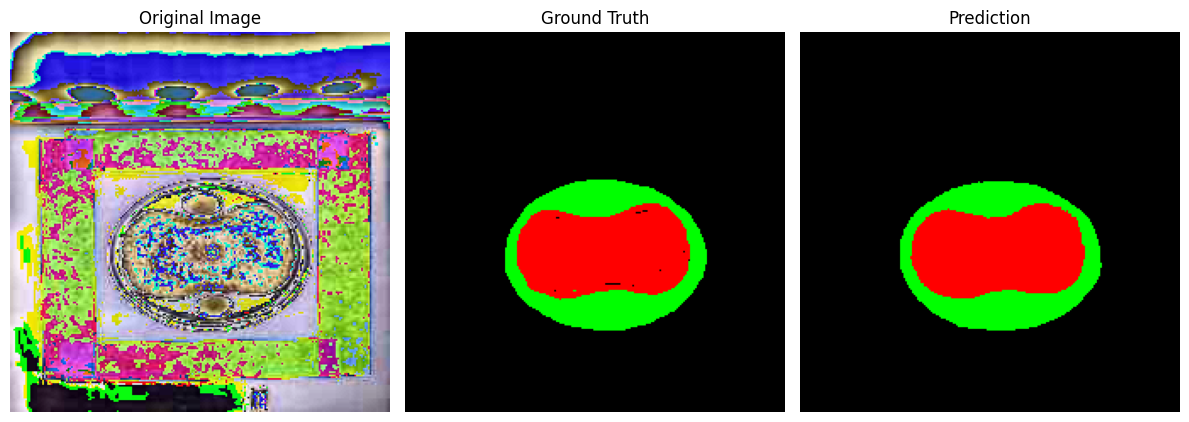

The original image looks weird because it has been normalized


In [50]:
showCompare(33)
print("The original image looks weird because it has been normalized")

In [51]:
from pathlib import Path          # NEW
import csv                        # NEW

### Use the entire data set (unlabeled as well)

In [ ]:

class InferenceDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = Path(image_dir)
        self.transform = transform
        self.image_files = sorted(
            f for f in self.image_dir.iterdir()
            if f.suffix.lower() == ".jpg" and f.is_file()
        )                                  

    def __len__(self):
        return len(self.image_files)
    # returns file name
    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        img = Image.open(img_path).convert("RGB")
        img = self.transform(img) if self.transform else T.ToTensor()(img)
        return img, img_path.name           


# predict, save, compute, and rank by top perecentage of pathogens
def run_full_inference(model,
                       image_dir="images_224_rename",
                       save_dir="labels/automated_labels",
                       top_n=20):

    save_dir = Path(save_dir)
    save_dir.mkdir(parents=True, exist_ok=True)

    # 1) build inference loader (no masks needed)
    inf_ds  = InferenceDataset(image_dir, transform=image_transform)
    inf_dl  = DataLoader(inf_ds, batch_size=4, shuffle=False)

    model.eval()
    print("\n  Saving predicted masks …")
    with torch.inference_mode():
        for imgs, names in inf_dl:
            imgs = imgs.to(device)
            outs = model(imgs)
            preds = torch.argmax(outs, dim=1).cpu().numpy()   # (B,H,W)

            for pred_np, fname in zip(preds, names):
                out_path = save_dir / f"{Path(fname).stem}_pred.png"
                Image.fromarray(pred_np.astype(np.uint8), mode="L").save(out_path)

    # 2) compute pixel statistics for every saved mask
    print("\n Computing pathogen area …")
    records, class_2 = [], 2    # class index 2  = pathogen
    for m_path in save_dir.glob("*_pred.png"):
        mask = np.array(Image.open(m_path))
        dish_px  = np.count_nonzero(mask == 1) + np.count_nonzero(mask == 2)
        path_px  = np.count_nonzero(mask == 2)
        pct      = 100 * path_px / dish_px if dish_px else 0
        records.append( (m_path.name, dish_px, path_px, pct) )

    # 3) put pathogen areas in a CSV
    csv_path = Path("pathogen_area_report.csv")
    with csv_path.open("w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["mask_file","dish_pixels",
                         "pathogen_pixels","percent_pathogen_area"])
        writer.writerows(records)

    # 4) rank & print
    by_pixels = sorted(records, key=lambda x: x[2], reverse=True)[:top_n]
    print(f"\n Top {top_n} cultures by absolute pathogen area:\n")
    for mf, dish, pat, pct in by_pixels:
        print(f"{mf:<25s}  pathogen_px={pat:>7d}   ({pct:5.2f} %)")

    print(f"\n✓  Full report saved to {csv_path.resolve()}\n")

# run the full inference model and report the top pathogen area percentages
run_full_inference(model,
                   image_dir=image_dir,
                   save_dir="labels/automated_labels",
                   top_n=20)



  Saving predicted masks …

 Computing pathogen area …

 Top 20 cultures by absolute pathogen area:

Dc - 90-3c_pred.png        pathogen_px=   6853   (89.36 %)
Dc - 90-3a_pred.png        pathogen_px=   6738   (85.09 %)
Dc - 178-1a_pred.png       pathogen_px=   6632   (85.18 %)
Dc - 90-1c_pred.png        pathogen_px=   6615   (78.70 %)
Dc - 178-3a_pred.png       pathogen_px=   6594   (79.37 %)
Dc - 178-2a_pred.png       pathogen_px=   6569   (80.59 %)
Dc - 90-1a_pred.png        pathogen_px=   6535   (86.07 %)
Dc - 53-1b_pred.png        pathogen_px=   6514   (76.00 %)
Dc - 178-3b_pred.png       pathogen_px=   6475   (78.37 %)
Dc - 93-3b_pred.png        pathogen_px=   6453   (80.55 %)
Dc - 178-2c_pred.png       pathogen_px=   6415   (80.02 %)
Dc - 90-2b_pred.png        pathogen_px=   6350   (80.54 %)
Dc - 53-1c_pred.png        pathogen_px=   6342   (69.82 %)
Dc - 28-1b_pred.png        pathogen_px=   6337   (69.36 %)
Dc - 178-3c_pred.png       pathogen_px=   6303   (82.16 %)
Dc - 65-1b_pr

Note: you may need to restart the kernel to use updated packages.


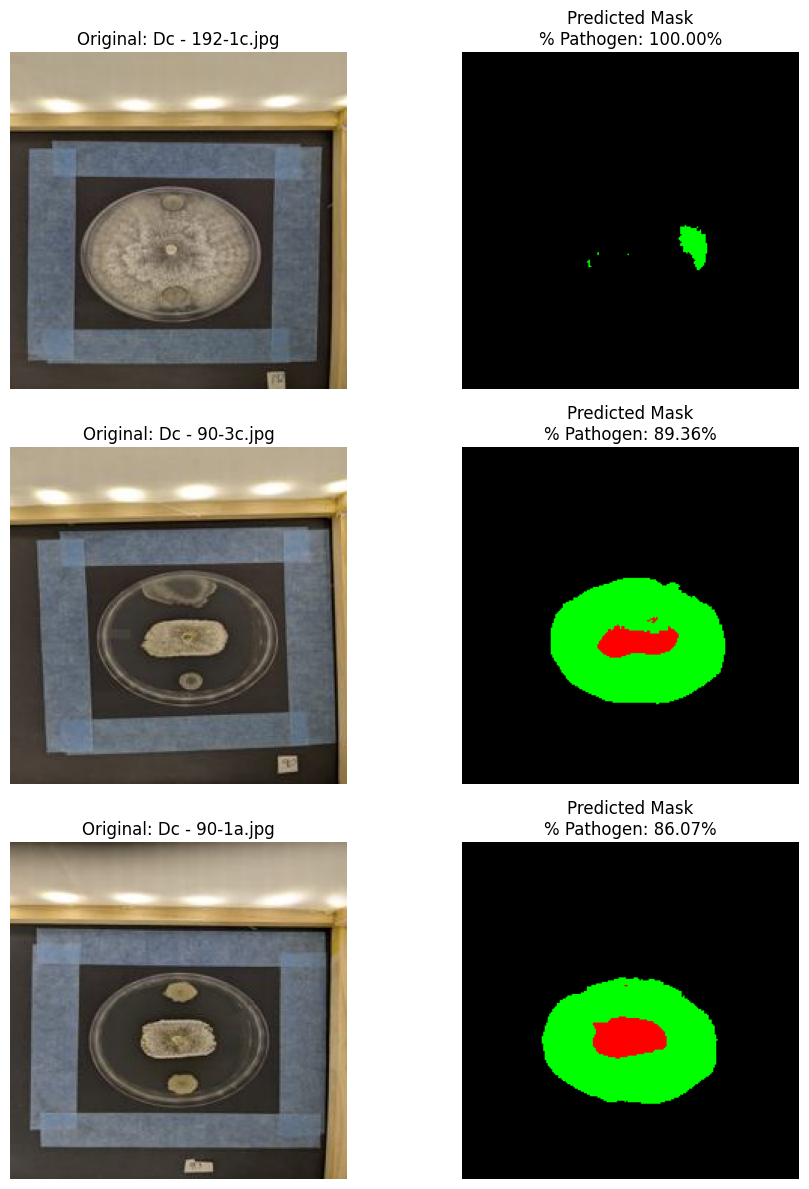

In [ ]:
# -----------------------------
# Visualize top 3 by percentage
# -----------------------------
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import pandas as pd

class_colors = {
    0: (0, 0, 0),       # background - black
    1: (255, 0, 0),     # pathogen - red
    2: (0, 255, 0),     # petri dish - green
}

def mask_to_color(mask, class_colors):
    color_mask = np.zeros((*mask.shape, 3), dtype=np.uint8)
    for class_idx, color in class_colors.items():
        color_mask[mask == class_idx] = color
    return color_mask

# Load CSV report
df = pd.read_csv("pathogen_area_report.csv")

# Sort by percentage, pick top 3
df_top_pct = df.sort_values("percent_pathogen_area", ascending=False).head(3)

# Plot original + predicted mask
fig, axes = plt.subplots(3, 2, figsize=(10, 12))
image_dir = Path(image_dir)
mask_dir = Path("labels/automated_labels")

for i, (_, row) in enumerate(df_top_pct.iterrows()):
    mask_file = row["mask_file"]
    base_name = Path(mask_file).stem.replace("_pred", "")
    img_path = image_dir / f"{base_name}.jpg"
    mask_path = mask_dir / mask_file

    # Load image and mask
    image = Image.open(img_path).convert("RGB")
    mask = np.array(Image.open(mask_path))
    color_mask = mask_to_color(mask, class_colors)

    # Original image
    axes[i, 0].imshow(image)
    axes[i, 0].set_title(f"Original: {base_name}.jpg")
    axes[i, 0].axis("off")

    # Mask
    axes[i, 1].imshow(color_mask)
    axes[i, 1].set_title(f"Predicted Mask\n% Pathogen: {row['percent_pathogen_area']:.2f}%")
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()


## Conclusion

Our U-Net–based transfer learning model demonstrates strong potential as a reliable tool for automated pathogen measurement on Petri dishes. The model achieves high agreement with manual measurements, as reflected by the following data anlysis done after the model was trained:

- **R² = 0.828**, indicating that the model explains over 82% of the variance in manual annotations.
- **MAE = 2.89%**, showing minimal average deviation from expert measurements.
- **RMSE = 6.16%** and **RSE = 6.19%**, suggesting consistent, bounded error across predictions.
- A **strong inverse correlation (r = -0.91)** between model output and manual scoring confirms that as transfer learning improves, manual effort could decrease.

![Petri Dish Prediction](pathogen_actual_vs_predicted.png)

### Together, these findings show that our approach enables **fast, reproducible, and expert-level quantification of pathogen growth**, significantly reducing time and variability associated with manual evaluation.


## HyperParameter Tuning
- **epoch**: around 20 we can reach 99% on training score, more than 20 may lead to overfitting.
- **batch_size**" our batch size is set to four because our manually labeled data size is only 50. Too large batch size may cause more training time in our model.
- **learning rate**: our learning rate is set to 1e-4. Since we have small train datasets and the epochs needed to train this model is around 20, this learning rate is pretty good in this project.


## Discussion
- **What worked:** The model achieved a high segmentation accuracy with consistently strong performance across validation sets. It also demonstrated efficient training behavior, converging in relatively few epochs, indicating both architectural soundness and appropriate hyperparameter tuning.


- **What didn't work**" The model underperformed on edge cases where the pathogen nearly covers the entire petri dish. These outliers, where pathogen coverage exceeds 80%, were not well represented in the training set—most of which contained 40–60% pathogen coverage. As a result, the model struggled to generalize to such extreme cases. Incorporating more diverse training samples, particularly with higher pathogen coverage, would likely improve the model’s robustness and overall performance.